In [46]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils import data

PROTO_POOL = 100


In [47]:
#------------------------Dataset preparation-------------------------#
# Loading
df = pd.read_csv("league-of-legends-diamond-ranked-games-10-min/high_diamond_ranked_10min.csv")

df = df.set_index(['gameId'])
df_indices = df.index

# Mapping labels to approrpriate output form
dic = {0: -1, 1: 1}
labels = df['blueWins'].map(dic)

df = df.drop(columns=['blueWins'])

# Normalisation
df = (df-df.mean())/df.std()

dataset = df.to_numpy()
labels = labels.to_numpy()

#Randomisation
random_indices = np.random.permutation(dataset.shape[0])
dataset = dataset[random_indices]
labels = labels[random_indices]

In [48]:
#----------------------Defining methods-----------------------------------#

def dist(a,b, distInd):
    if(distInd == 0):
        return np.linalg.norm(a-b)
    else:
        return np.sum(np.abs(a-b))

def distarray(x, arr, distInd): #Returns the distance of each vector from arr and x
    result_array = np.array([])
    for row in arr:
        result_array = np.append(result_array, dist(x,row, distInd))
    return result_array[result_array > 0.00001]

def minDist(x, arr, n, distInd): #Returns the indices of the n least distances
    return np.argsort(distarray(x, arr, distInd))[:n]

In [49]:
#-----------------------Creating prototypes ----------------------------#

protoset = dataset[0:PROTO_POOL]
protolabels = labels[0:PROTO_POOL]

prototypes_eucl = np.zeros((1, protoset.shape[-1]))
typeslabel_eucl = np.zeros((1,))
prototypes_man = np.zeros((1, protoset.shape[-1]))
typeslabel_man = np.zeros((1,))

prototypes_eucl[0] = np.array([protoset[0]])
typeslabel_eucl[0] = np.array([labels[0]])
prototypes_man[0] = np.array([protoset[0]])
typeslabel_man[0] = np.array([labels[0]])
#print(prototypes)
for i in range(1,PROTO_POOL):
    index_min_dist_eucl = minDist(protoset[i], prototypes_eucl,1, 0)
    index_min_dist_man = minDist(protoset[i], prototypes_man,1, 1)

    if((typeslabel_eucl[index_min_dist_eucl[0]] != protolabels[i])):
        prototypes_eucl = np.vstack([prototypes_eucl, protoset[i]])
        typeslabel_eucl = np.append(typeslabel_eucl, labels[i])

    if((typeslabel_man[index_min_dist_man[0]] != protolabels[i])):
        prototypes_man = np.vstack([prototypes_man, protoset[i]])
        typeslabel_man = np.append(typeslabel_man, labels[i])

print(len(prototypes_man))
print(len(prototypes_eucl))
#--------------------------Computation-------------------------------#
number_neighbors = 1
sizes = []
accuracies_eucl = []
accuracies_man = []
accuracy = 0;
while (number_neighbors < np.minimum(len(prototypes_man), len(prototypes_eucl))):

    print('K = ', number_neighbors)

    guessedLabels_eucl= np.zeros(labels.shape)
    guessedLabels_man= np.zeros(labels.shape)

    for i in range(PROTO_POOL, dataset.shape[0]):
        guessedLabels_eucl[i] = np.sign(np.sum(typeslabel_eucl[minDist(dataset[i], prototypes_eucl,number_neighbors, 0)]))
        guessedLabels_man[i] = np.sign(np.sum(typeslabel_man[minDist(dataset[i], prototypes_man,number_neighbors, 0)]))

    guesses_eucl = guessedLabels_eucl[100:len(guessedLabels_eucl)] + labels[100:len(labels)]
    accuracy = np.count_nonzero(guesses_eucl)/len(guesses_eucl)
    accuracies_eucl.append(accuracy)

    guesses_man = guessedLabels_man[100:len(guessedLabels_man)] + labels[100:len(labels)]
    accuracy = np.count_nonzero(guesses_man)/len(guesses_man)
    accuracies_man.append(accuracy)


    sizes.append(number_neighbors)
    number_neighbors += 2    

54
50
K =  1
K =  3
K =  5
K =  7
K =  9
K =  11
K =  13
K =  15
K =  17
K =  19
K =  21
K =  23
K =  25
K =  27
K =  29
K =  31
K =  33
K =  35
K =  37
K =  39
K =  41
K =  43
K =  45
K =  47
K =  49


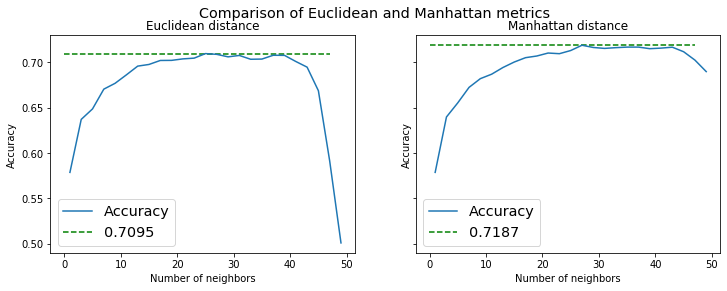

In [51]:
#----------------------------Graphs------------------------------#
import matplotlib.pyplot as plt

max_acc_eucl = np.max(accuracies_eucl)
max_acc_man = np.max(accuracies_man)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize = (12,4))
#fig.suptitle('Validation, training and test average log-likelihoods with different parameters for learning rate and bacth size')

fig.suptitle('Comparison of Euclidean and Manhattan metrics', fontsize = 'x-large')
axs[0].plot(sizes,accuracies_eucl, label = 'Accuracy')
axs[0].set_title('Euclidean distance')
axs[0].set_xlabel('Number of neighbors')
axs[0].set_ylabel('Accuracy')
axs[0].hlines(max_acc_eucl, 0, 47, linestyles='dashed', colors='green', label = np.around(max_acc_eucl,4))
axs[0].legend(fontsize= 'x-large', loc = 'lower left')

axs[1].plot(sizes,accuracies_man, label = 'Accuracy')
axs[1].set_title('Manhattan distance')
axs[1].set_xlabel('Number of neighbors')
axs[1].set_ylabel('Accuracy')
axs[1].hlines(max_acc_man, 0, 47, linestyles='dashed', colors='green', label = np.around(max_acc_man,4))
axs[1].legend(fontsize='x-large', loc = 'lower left')
plt.show()

In [52]:
fig.savefig("knn-comp")